In [1]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

from flopco import FlopCo

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/home/d.cherniuk/.conda/mark23/lib/python3.9/site-packages/tqdm-4.64.1-py3.9.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_layer_by_name(model, mname):
    '''
    Extract layer using layer name
    '''
    module = model
    mname_list = mname.split('.')
    for mname in mname_list:
        module = module._modules[mname]

    return module

# admm factors

In [26]:
def hist_factors(bits, lname, method, rank, seed=42):
    factors = [
      torch.load(f'../../{bits}bit_symmetric/factors_{method}_seed{seed}/{lname}_{method}_random_rank_{rank}_mode_0.pt',
                 map_location='cpu'),
      torch.load(f'../../{bits}bit_symmetric/factors_{method}_seed{seed}/{lname}_{method}_random_rank_{rank}_mode_1.pt',
                 map_location='cpu'),
      torch.load(f'../../{bits}bit_symmetric/factors_{method}_seed{seed}/{lname}_{method}_random_rank_{rank}_mode_2.pt',
                 map_location='cpu'),
    ]
    
    fig, axs = plt.subplots(1, 3, figsize=(10,3))
    bins = min(2**bits, 100)
    i = 0 
    for factor in factors:
        axs[i].hist(factor.flatten().numpy(), bins=bins, color='royalblue')
        i += 1
    fig.suptitle(f'layer={lname} bits={bits} rank={rank} {method}', fontsize=16)
    plt.show()

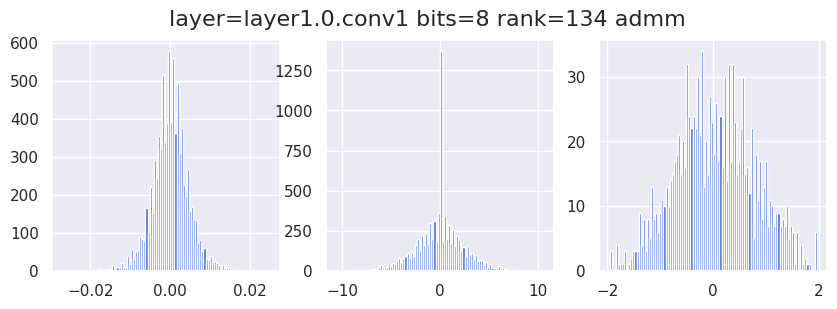

In [27]:
hist_factors(bits=8, lname='layer1.0.conv1', method='admm', rank=134)

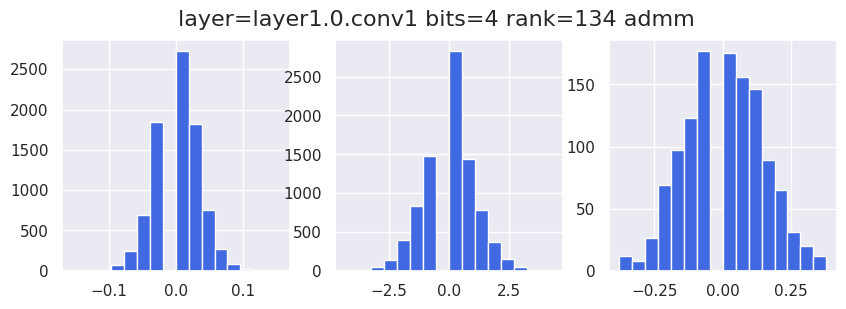

In [28]:
hist_factors(bits=4, lname='layer1.0.conv1', method='admm', rank=134)

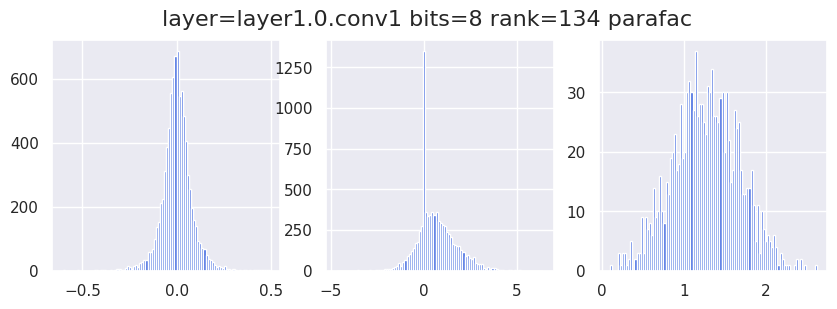

In [32]:
hist_factors(bits=8, lname='layer1.0.conv1', method='parafac', rank=134)

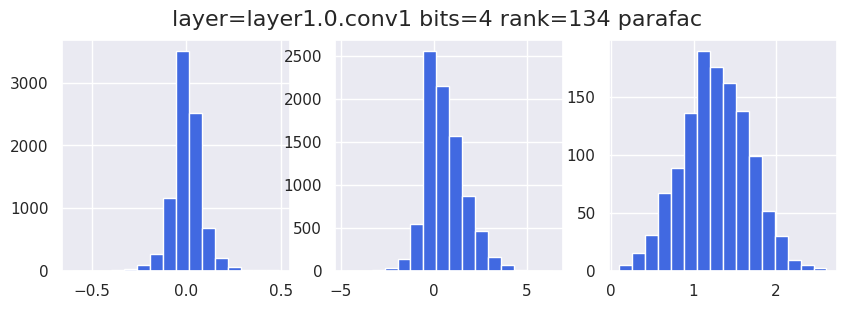

In [35]:
hist_factors(bits=4, lname='layer1.0.conv1', method='parafac', rank=134)

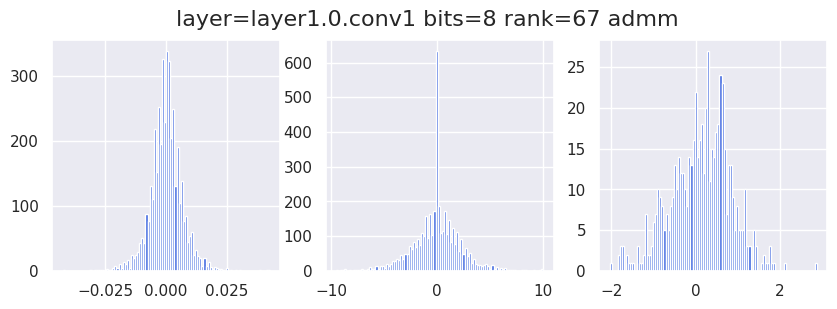

In [34]:
hist_factors(bits=8, lname='layer1.0.conv1', method='admm', rank=67)

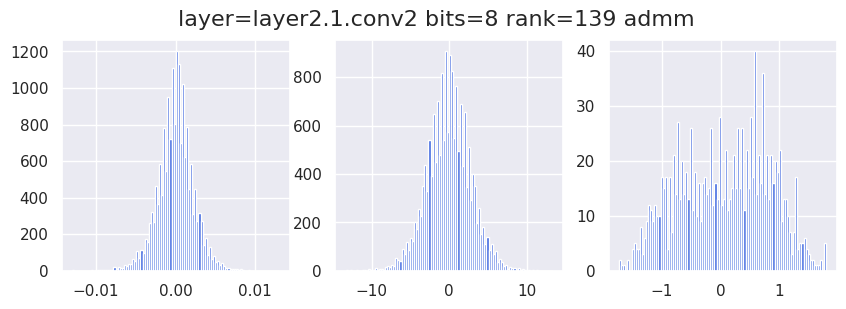

In [38]:
hist_factors(bits=8, lname='layer2.1.conv2', method='admm', rank=139)

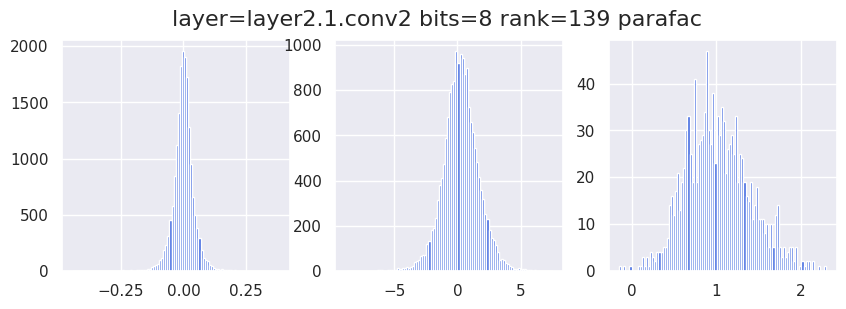

In [39]:
hist_factors(bits=8, lname='layer2.1.conv2', method='parafac', rank=139)

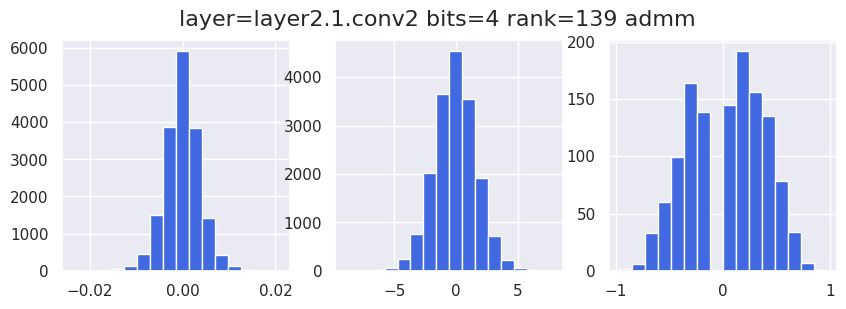

In [40]:
hist_factors(bits=4, lname='layer2.1.conv2', method='admm', rank=139)

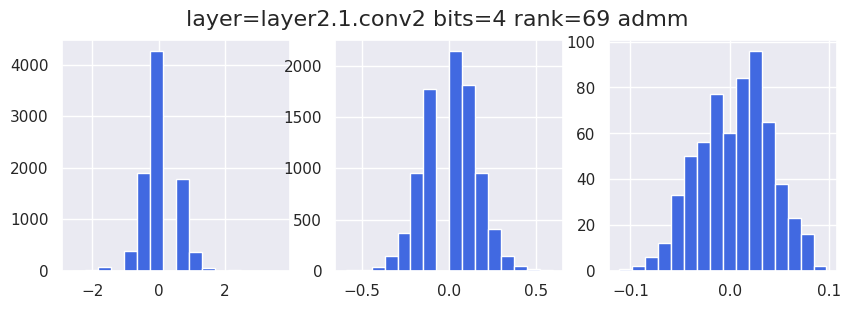

In [41]:
hist_factors(bits=4, lname='layer2.1.conv2', method='admm', rank=69)

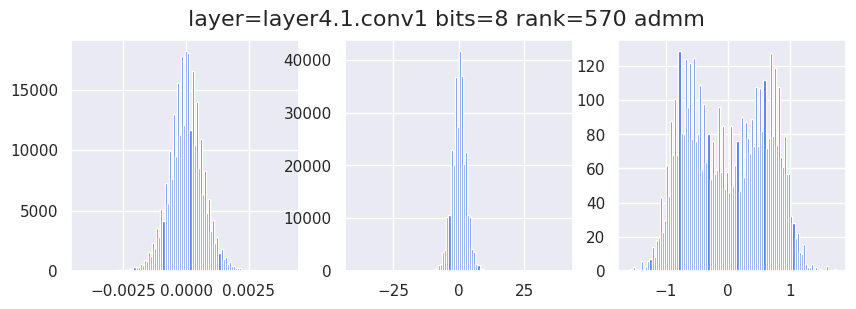

In [44]:
hist_factors(bits=8, lname='layer4.1.conv1', method='admm', rank=570)

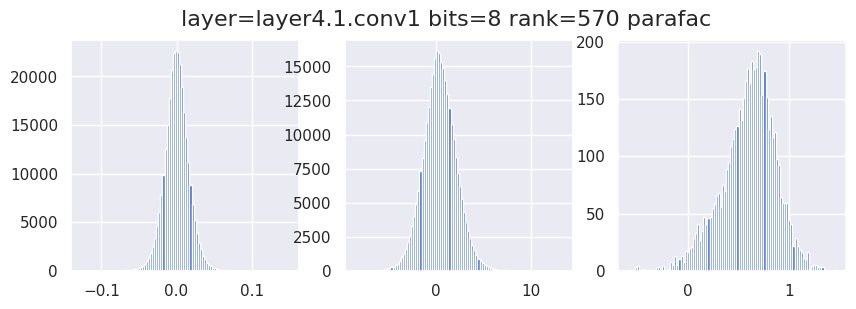

In [45]:
hist_factors(bits=8, lname='layer4.1.conv1', method='parafac', rank=570)

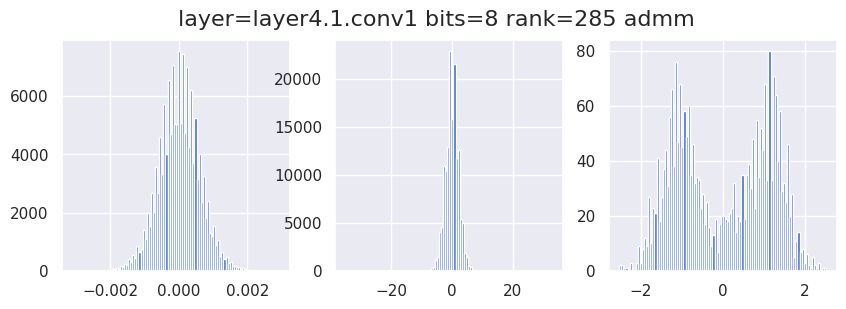

In [46]:
hist_factors(bits=8, lname='layer4.1.conv1', method='admm', rank=285)

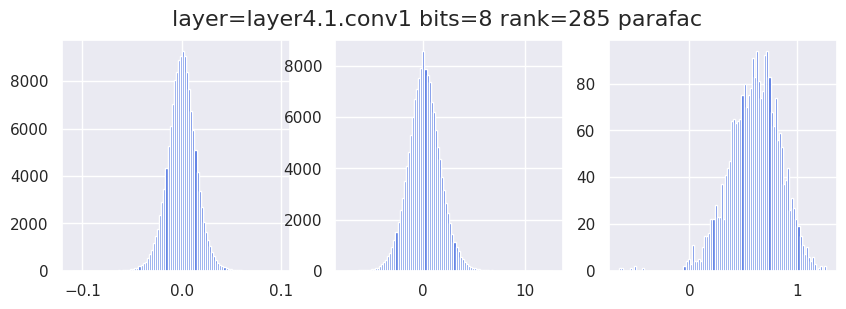

In [47]:
hist_factors(bits=8, lname='layer4.1.conv1', method='parafac', rank=285)

# original weights

In [2]:
model = resnet18(pretrained=True)
model.eval()

/home/d.cherniuk/.conda/mark23/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/d.cherniuk/.conda/mark23/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
model_stats = FlopCo(model, img_size=(1, 3, 224, 224), device='cpu')
all_lnames = list(model_stats.flops.keys())

lnames_to_hist = [k for k in all_lnames if model_stats.ltypes[k]['type'] == nn.Conv2d \
                      and k != 'conv1' and 'downsample' not in k]

In [18]:
len(lnames_to_hist)

16

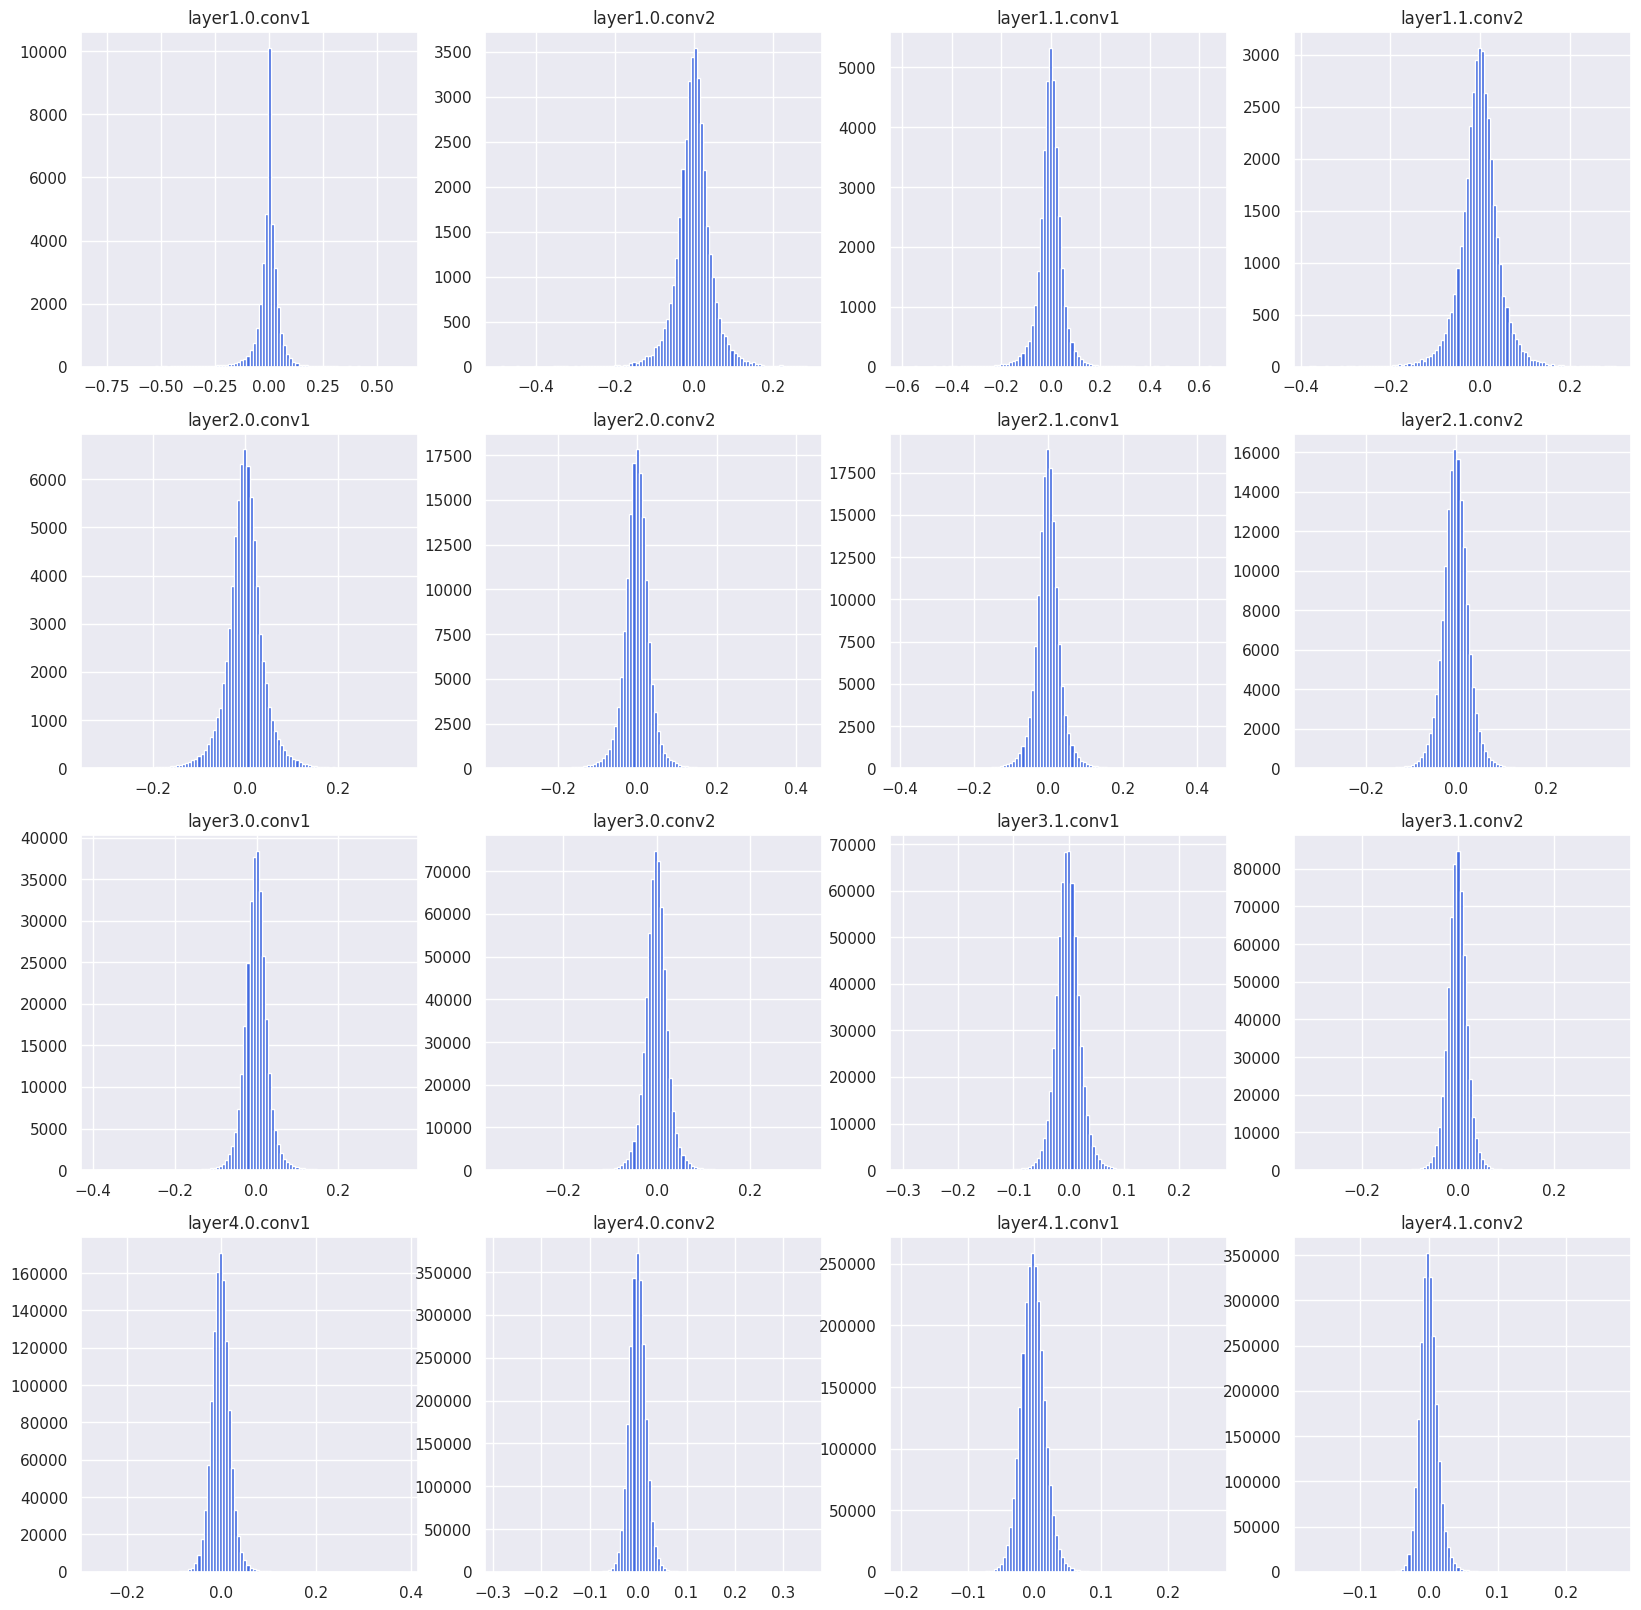

In [23]:
fig, axs = plt.subplots(4, 4, figsize=(20,20))

i = 0 
for lname in lnames_to_hist:
    layer = get_layer_by_name(model, lname)
    axs[i//4][i%4].hist(layer.weight.detach().flatten().numpy(), bins=100, color='royalblue')
    axs[i//4][i%4].set_title(lname)
    i += 1

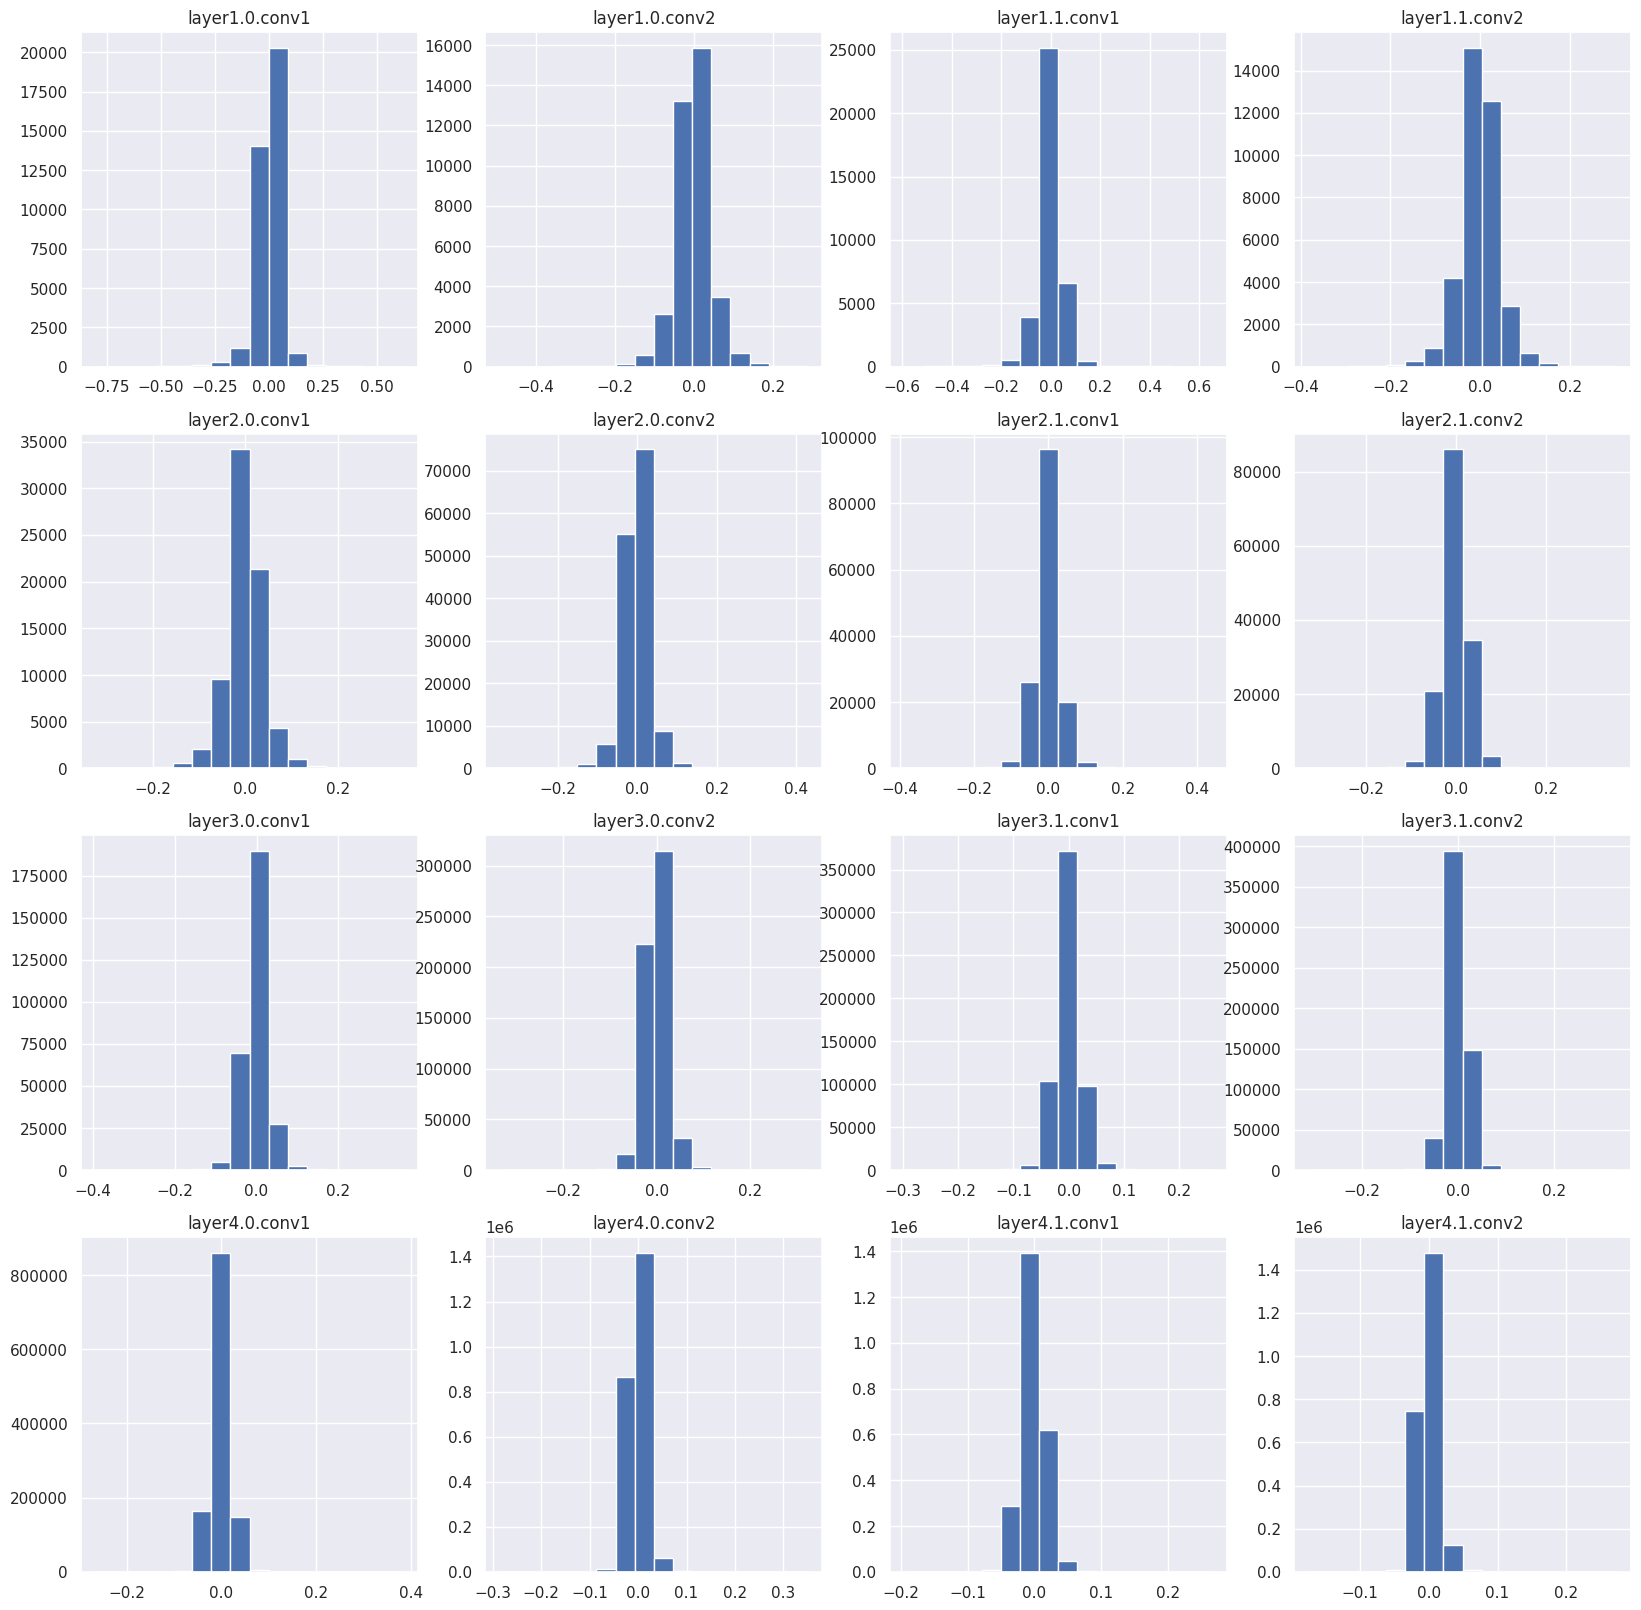

In [21]:
bits = 4
fig, axs = plt.subplots(4, 4, figsize=(20,20))

i = 0 
for lname in lnames_to_hist:
    layer = get_layer_by_name(model, lname)
    axs[i//4][i%4].hist(layer.weight.detach().flatten().numpy(), bins=2**bits)
    axs[i//4][i%4].set_title(lname)
    i += 1